# Inception Model V3
* source: https://keras.io/api/applications/#usage-examples-for-image-classification-models, https://keras.io/api/applications/inceptionv3/

In [1]:
model_name = 'InceptionV3-baseline-3'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from numba import cuda  # https://stackoverflow.com/a/52354865/6476994
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from datetime import datetime
import keras

In [3]:
# allows all images to be displayed at once (else only displays the last call to plt.imshow())
# https://stackoverflow.com/a/41210974
def displayImage(image, caption = None, colour = None) -> None:
    plt.figure()
    if(colour != None):
        plt.imshow(image, cmap=colour)
    else:
        plt.imshow(image)
        
    if(caption != None):
        # display caption below picture (https://stackoverflow.com/a/51486361)
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

In [4]:
# free up GPU if it didn't after the last run
cuda.select_device(0)
cuda.close()

## Read in dataset

* first argument is the `using_batch_generator` flag
* second argument is `do_preprocessing`, which will perform image manipulations for the purposes of enhancing training performance
* all other arguments are the datasets - e.g., a folder ('20160724_July') with additional folders ('BB01', 'BB02', ..., 'BBXY'), each containing a set of images)

In [5]:
%run readInDataset.py true false 20160724_July 20160829_August

args: ['readInDataset.py', 'true', 'false', '20160724_July', '20160829_August']
using_batch_generator? True
doing pre-processing? False
dataset_names: ['20160724_July', '20160829_August']
reading in images and labels for dataset: 20160724_July
all_folders_for_curr_dataset: ['BB01', 'BB02', 'BB03', 'BB04', 'BB05', 'BB06', 'BB07', 'BB08', 'BB09', 'BB10', 'BB11', 'BB12', 'BB13', 'BB14', 'BB15', 'BB16', 'BB17', 'BB18', 'BB19', 'BB20', 'BB21', 'BB22', 'BB23', 'BB24', 'BB25', 'BB26', 'BB27', 'BB28', 'BB29', 'BB30', 'BB31', 'BB32', 'BB33', 'BB34', 'BB35', 'BB36']
reading in labels for subset: BB01
returning labelList of length: 285
reading in images for subset: BB01
all_image_filenames length: 285
done current subset
reading in labels for subset: BB02
returning labelList of length: 45
reading in images for subset: BB02
all_image_filenames length: 45
done current subset
reading in labels for subset: BB03
returning labelList of length: 230
reading in images for subset: BB03
all_image_filenames 

In [6]:
class CustomGenerator(keras.utils.Sequence):    
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        return batch_x, np.array(batch_y)

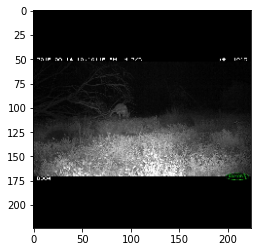

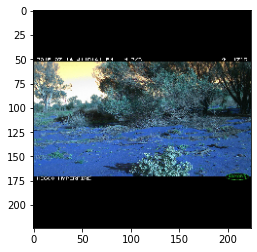

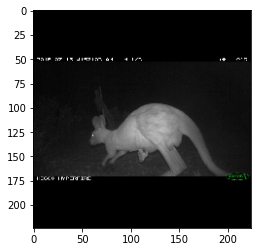

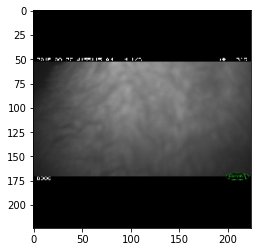

In [7]:
batch_size = 128

num_len_train = int(0.8 * len(training_images))

ttraining_images = training_images[:num_len_train]
ttraining_labels = training_labels[:num_len_train]

valid_images = training_images[num_len_train:]
valid_labels = training_labels[num_len_train:]

training_images = ttraining_images
training_labels = ttraining_labels

# show a few samples
displayImage(training_images[0])
displayImage(training_images[10])
displayImage(training_images[100])
displayImage(training_images[1000])

training_batch_generator = CustomGenerator(training_images, training_labels, batch_size)
validation_batch_generator = CustomGenerator(valid_images, valid_labels, batch_size)

## Train the model

In [8]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- based on number of classes
predictions = Dense(len(classes), activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
# model.fit(training_images, training_labels, batch_size=128,
#           validation_data=(valid_images, valid_labels),
#           epochs = 10)
model.fit(training_batch_generator,
          validation_data=validation_batch_generator,
          epochs=10)

2022-06-06 08:29:00.524374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 08:29:00.527654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 08:29:00.527854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 08:29:00.528169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/10


/tmp/ipykernel_88208/4098404636.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
2022-06-06 08:29:04.567262: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-06-06 08:29:04.881515: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update

89/89 [==============================] - 24s 213ms/step - loss: 26.3522 - val_loss: 7.8335
Epoch 2/10
89/89 [==============================] - 16s 175ms/step - loss: 7.0200 - val_loss: 2.0514
Epoch 3/10
89/89 [==============================] - 16s 177ms/step - loss: 3.4146 - val_loss: 1.3331
Epoch 4/10
89/89 [==============================] - 16s 176ms/step - loss: 1.6972 - val_loss: 2.1445
Epoch 5/10
89/89 [==============================] - 16s 178ms/step - loss: 1.1989 - val_loss: 0.7793
Epoch 6/10
89/89 [==============================] - 16s 177ms/step - loss: 1.0068 - val_loss: 0.8613
Epoch 7/10
89/89 [==============================] - 16s 178ms/step - loss: 0.8881 - val_loss: 0.8039
Epoch 8/10
89/89 [==============================] - 16s 178ms/step - loss: 0.8471 - val_loss: 0.8119
Epoch 9/10
89/89 [==============================] - 16s 178ms/step - loss: 0.8087 - val_loss: 0.8940
Epoch 10/10
89/89 [==============================] - 16s 178ms/step - loss: 0.7669 - val_loss: 0.6950

In [9]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# model.fit(training_images, training_labels, batch_size=128,
#           validation_data=(valid_images, valid_labels),
#           epochs = 90)
model.fit(training_batch_generator,
          validation_data=validation_batch_generator,
          epochs=90)

Epoch 1/90


/home/luke/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/tmp/ipykernel_88208/4098404636.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)


89/89 [==============================] - 23s 226ms/step - loss: 1.1282 - val_loss: 1.0177
Epoch 2/90
89/89 [==============================] - 19s 209ms/step - loss: 0.9892 - val_loss: 0.9559
Epoch 3/90
89/89 [==============================] - 19s 214ms/step - loss: 0.9379 - val_loss: 0.9055
Epoch 4/90
89/89 [==============================] - 20s 225ms/step - loss: 0.9013 - val_loss: 0.8744
Epoch 5/90
89/89 [==============================] - 19s 215ms/step - loss: 0.8706 - val_loss: 0.8494
Epoch 6/90
89/89 [==============================] - 19s 213ms/step - loss: 0.8426 - val_loss: 0.8260
Epoch 7/90
89/89 [==============================] - 19s 211ms/step - loss: 0.8165 - val_loss: 0.8039
Epoch 8/90
89/89 [==============================] - 19s 210ms/step - loss: 0.7913 - val_loss: 0.7826
Epoch 9/90
89/89 [==============================] - 19s 211ms/step - loss: 0.7671 - val_loss: 0.7628
Epoch 10/90
89/89 [==============================] - 19s 210ms/step - loss: 0.7439 - val_loss: 0.7437


## Use test set to assess trained model's performance

### Evaluate

In [10]:
print('test_images shape: {}'.format(test_images.shape))
print('test_labels shape: {}'.format(test_labels.shape))

results = model.evaluate(test_images,test_labels)
print('loss: {}'.format(results))

test_images shape: (3556, 224, 224, 3)
test_labels shape: (3556, 10)
112/112 [==============================] - 6s 48ms/step - loss: 0.4481
loss: 0.4481348395347595


### Predict and print classification report

In [11]:
predictions = (model.predict(test_images) > 0.5).astype("int32")

112/112 [==============================] - 5s 40ms/step


In [12]:
print("test_classes: {}".format(test_classes))
print("train classes count: {}".format(counter_test))
# classification_report uses alphabetic ordering of the classes, so to match the encoded labels to the target_names, provide a sortest list of classes
# https://stackoverflow.com/a/48495303
sorted_test_classes = sorted(test_classes)
print(classification_report(test_labels, predictions, target_names=sorted_test_classes))

test_classes: ['Emu', 'Kangaroo', 'Fox', 'Human Presense/Deployment', 'Empty photo', 'Cat', 'Dog', 'Rabbit', 'Bird', 'Other']
train classes count: Counter({'Kangaroo': 2346, 'Empty photo': 632, 'Emu': 240, 'Human Presense/Deployment': 194, 'Fox': 78, 'Cat': 36, 'Rabbit': 15, 'Other': 8, 'Bird': 6, 'Dog': 1})
                           precision    recall  f1-score   support

                     Bird       0.00      0.00      0.00         6
                      Cat       0.00      0.00      0.00        36
                      Dog       0.00      0.00      0.00         1
              Empty photo       0.77      0.78      0.78       632
                      Emu       0.86      0.85      0.86       240
                      Fox       1.00      0.04      0.07        78
Human Presense/Deployment       0.86      0.67      0.75       194
                 Kangaroo       0.94      0.95      0.95      2346
                    Other       0.00      0.00      0.00         8
                   

/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion matrix

In [13]:
matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
print(matrix)

[[   3    0    0    3    0    0    0    0    0    0]
 [  12    0    0   15    0    0    2    7    0    0]
 [   0    0    0    0    1    0    0    0    0    0]
 [  42    0    0  496    8    0    8   78    0    0]
 [  11    0    0   10  205    0    3   11    0    0]
 [  33    0    0   19    0    3    2   21    0    0]
 [  22    0    0   12   14    0  130   16    0    0]
 [  17    0    0   82   10    0    6 2231    0    0]
 [   1    0    0    2    1    0    1    3    0    0]
 [   6    0    0    6    0    0    0    3    0    0]]


### Accuracy

In [14]:
acc = accuracy_score(test_labels, predictions)
print(acc)

0.8619235095613048


## Save the model
* use the current date/time so we can keep incrementation progress of the model as we re-run it

In [15]:
if model_name == None:
    now = datetime.now()
    dt_string = now.strftime('%d-%m-%Y_%H:%M:%S')
    print("saving model as: 'InceptionV3-{}.h5'.'".format(dt_string))

    model.save('saved_models/InceptionV3-{}.h5'.format(dt_string))
else:
    print("saving model as: '{}.h5'.'".format(model_name))
    model.save('saved_models/final/{}.h5'.format(model_name))

saving model as: 'InceptionV3-baseline-3.h5'.'


## Free up the GPU's memory

In [16]:
cuda.select_device(0)
cuda.close()